In [99]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, GRU, Bidirectional
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [100]:
# Prepare data file location and name
data_file_location = ".//data//"
data_file_name_train = "train"
data_file_name_validate = "validate"
data_file_name_test = "test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [101]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1020, 6)
Validation Dataset Shape: (256, 6)
Testing Dataset Shape: (319, 6)


In [102]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close    Volume        Date
0  0.017928  0.021593  0.020518  0.025882  0.288676  2019-01-02
1  0.000000  0.000000  0.000000  0.000000  0.843448  2019-01-03
2  0.000904  0.004654  0.003020  0.009987  0.509137  2019-01-04
3  0.007756  0.005115  0.006543  0.009444  0.469994  2019-01-07
4  0.009170  0.010032  0.010939  0.014084  0.329416  2019-01-08
Validation Dataset:
       Open      High       Low     Close    Volume        Date
0  0.684705  0.701039  0.694996  0.706173  0.115068  2023-01-20
1  0.704047  0.737162  0.720584  0.728267  0.118995  2023-01-23
2  0.718962  0.736072  0.737271  0.737950  0.079832  2023-01-24
3  0.722912  0.731096  0.726911  0.733381  0.078207  2023-01-25
4  0.738439  0.743500  0.748396  0.747701  0.048322  2023-01-26
Testing Dataset:
       Open      High       Low     Close    Volume        Date
0  1.078368  1.077629  1.087283  1.080750  0.030537  2024-01-29
1  1.071040  1.074888  1.072530  1.055447  0.0528

In [103]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [104]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [105]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [106]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [107]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [108]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [109]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1595, 5)

 Data Train Scaled: (1020, 5)
> Data Train X: (960, 60, 5)
> Data Train y: (960,)

 Data Validate Scaled: (256, 5)
> Data Validate X: (256, 60, 5)
> Data Validate y: (256,)

 Data Test Scaled: (319, 5)
> Data Test X: (319, 60, 5)
> Data Test y: (319,)


In [110]:
# Initializing the model
regressor = Sequential()

In [111]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Bidirectional(GRU(units=100, return_sequences=True)))

In [112]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [113]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [114]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [115]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [116]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [117]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [118]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = ".//models//"
model_name = "stock_price.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss", 
    save_best_only=True, 
    mode="min", 
    verbose=0)


In [119]:
# Training the model
history = regressor.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate), 
    epochs=100, 
    batch_size = 64, 
    callbacks = [best_model_checkpoint_callback])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.1103 - val_loss: 0.0210
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0037 - val_loss: 0.0065
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0038 - val_loss: 0.0070
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2

Epoch 68/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 69/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0014 - val_loss: 5.0299e-04
Epoch 70/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0017 - val_loss: 4.7907e-04
Epoch 71/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0014 - val_loss: 5.1194e-04
Epoch 72/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0016 - val_loss: 6.3834e-04
Epoch 73/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0015 - val_loss: 7.8861e-04
Epoch 74/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0014 - val_loss: 7.8299e-04
Epoch 75/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 76/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0016 - val_loss: 4.9974e-04
Epoch 77/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 78/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.0015 - val_loss: 0.0011
Epoc

In [120]:
regressor.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 60, 200)             │          64,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 60, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,277,705 (4.87 MB)

 Trainable params: 425,901 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 851,804 (3.25 MB)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
RMSE: 0.1070
MAE: 0.0863
R²: 0.6060


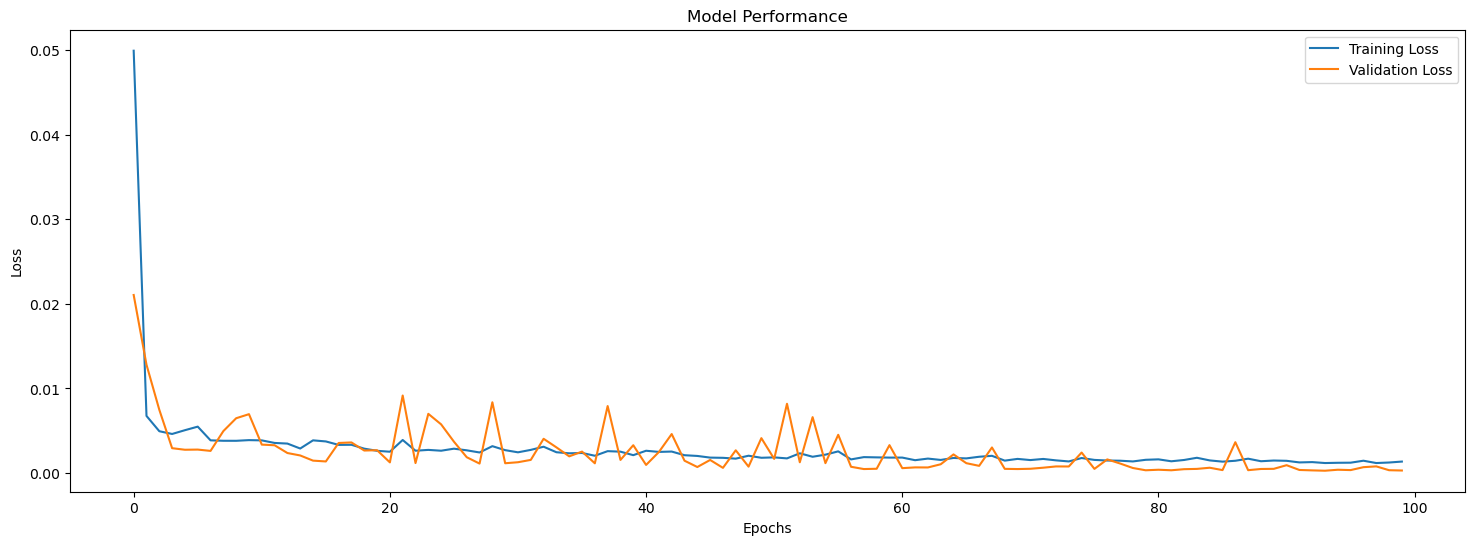

In [121]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have a trained model and a test set (X_test, y_test)
# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Display the evaluation results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plotting model performance during training
plt.figure(figsize=(18, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [122]:
# Prepare model location and name
model_location = ".//models//"
model_name = "stock_price.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [123]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [124]:
# Prepare scaler model name and location
scaler_model_location = ".//models//"
scaler_model_name = "dataset_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_location + scaler_model_name + "." + scaler_model_ext)

In [125]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 4))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 4))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 4))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 4))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 4))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 4))), axis=1))[:,0]

In [126]:
# Define chart colors
train_actual_color = "lightblue"
validate_actual_color = "yellow"
test_actual_color = "lightgreen"
train_predicted_color = "violet"
validate_predicted_color = "red"
test_predicted_color = "green"

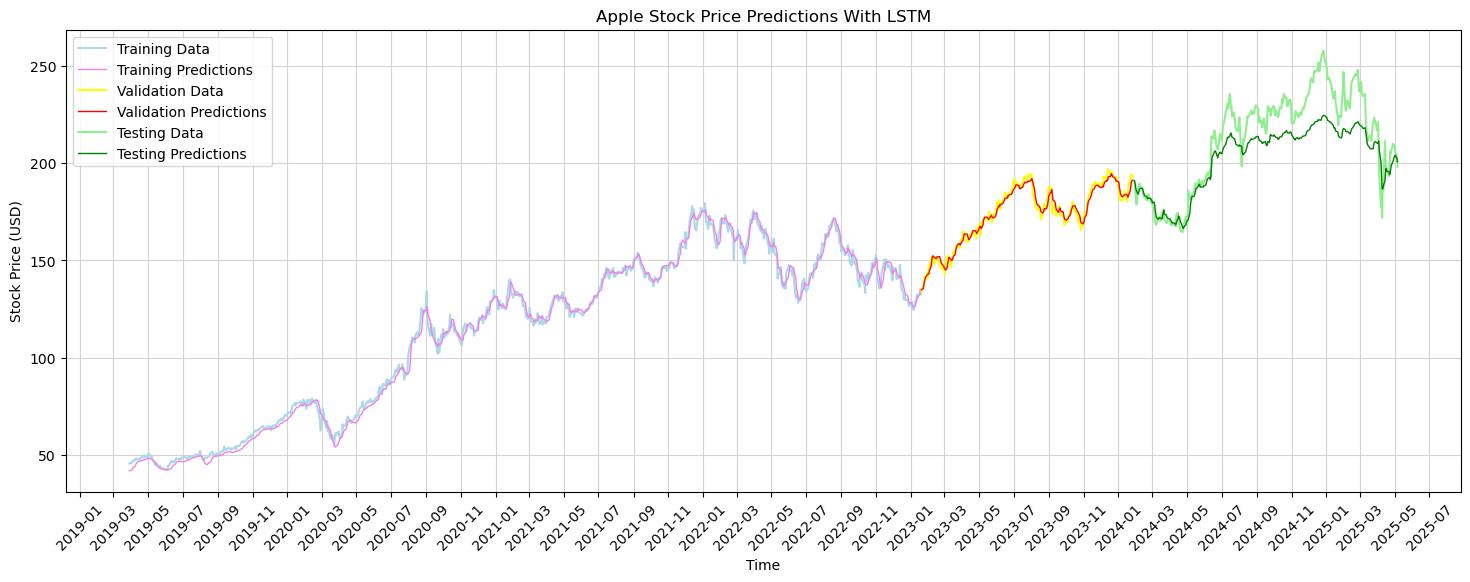

In [127]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Apple Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

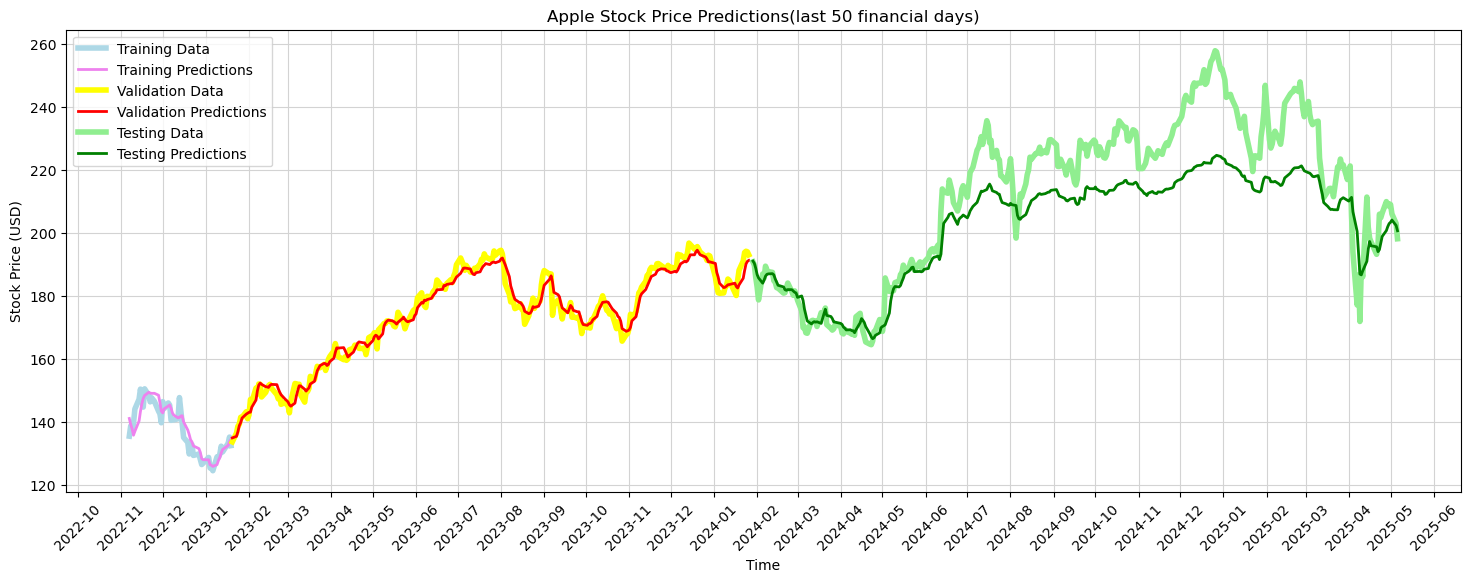

In [128]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Apple Stock Price Predictions(last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")